In [1]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

etfs = ['XLE', 'XLF', 'XLK', 'XLI', 'XLB', 'XLV', 'XLY', 'XLP', 'XLU', 'XLRE']

prices = yf.download(etfs, start = '2015-01-01', end = '2020-01-01')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_7491/2352832364.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(etfs, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  10 of 10 completed


In [ ]:
# rolling cointegration

window_size = 252
min_passes = 0.3
step = 21

candidate_pairs = []
cointegrated_pairs = []

category_prices = prices[etfs]

for i in range(len(etfs)):
    for j in range(i + 1, len(etfs)):
        candidate_pairs.append([etfs[i], etfs[j]])

for etf1, etf2 in candidate_pairs:
            
    df = category_prices[[etf1, etf2]].dropna()

    series1 = df.iloc[:, 0]
    series2 = df.iloc[:, 1]

    cointegrated_windows = 0
    total_windows = 0

    for start in range(0, len(df) - window_size + 1, step):
        end = start + window_size

        window_s1 = series1.iloc[start:end]
        window_s2 = series2.iloc[start:end]
                
        score, pvalue, _ = coint(window_s1, window_s2)
        total_windows += 1
                
        if pvalue < 0.1:
            cointegrated_windows += 1

    if cointegrated_windows / total_windows >= min_passes:
        cointegrated_pairs.append({'ETF1': etf1, 'ETF2': etf2, 'Pass %': cointegrated_windows / total_windows})


cointegrated_pairs_df = pd.DataFrame(cointegrated_pairs)

cointegrated_pairs_df = cointegrated_pairs_df.sort_values('Pass %', ascending = False).reset_index(drop = True)
print(f'Rolling Cointegrated Pairs:')
print(cointegrated_pairs_df)


Rolling Cointegrated Pairs:
  ETF1  ETF2    Pass %
0  XLV   XLU  0.458333
1  XLP   XLU  0.416667
2  XLV  XLRE  0.384615
3  XLI   XLB  0.354167
4  XLB   XLY  0.354167
5  XLU  XLRE  0.307692


Clusters:
    ETF  Cluster        PC1        PC2
0   XLE        2  27.456878  33.724075
1   XLF        0  15.745329 -10.012456
2   XLK        0   5.841994 -16.808740
3   XLI        0   9.320831  -5.194808
4   XLB        0  12.067419  -0.055309
5   XLV        0  -1.610207 -10.350521
6   XLY        0   4.497927 -10.778832
7   XLP        1 -15.075074   0.188418
8   XLU        1 -32.832166  12.966177
9  XLRE        1 -25.412930   6.321997


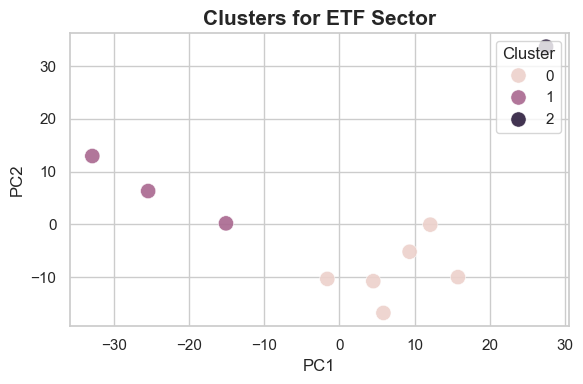

In [ ]:
# k-means / PCA

category_prices = prices[etfs]

returns = category_prices.pct_change().dropna()

scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns.T)

pca = PCA(n_components = 2)
pca_components = pca.fit_transform(returns_scaled)

max_clusters = min(len(etfs) - 1, 10)

best_k = 2
best_score = -1

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(pca_components)
    score = silhouette_score(pca_components, labels)

    if score > best_score:
        best_score = score
        best_k = k

kmeans = KMeans(n_clusters = best_k, random_state = 42)
labels = kmeans.fit_predict(pca_components)

cluster_df = pd.DataFrame({
    'ETF': returns.columns,
    'Cluster': labels,
    'PC1': pca_components[:, 0],
    'PC2': pca_components[:, 1]
})

print(f'Clusters:')
print(cluster_df)

sns.set_theme(style = 'whitegrid', font_scale = 1)

plt.figure(figsize = (6, 4))

sns.scatterplot(
    data = cluster_df,
    x = 'PC1',        
    y = 'PC2',
    hue = 'Cluster',
    s = 120, 
    linewidth = 0.4,
    alpha = 0.9 
)

plt.title(f'Clusters for ETF Sector', fontsize = 15, weight = 'bold')
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)

plt.legend(title = 'Cluster', loc='upper right', frameon = True)

plt.tight_layout()
plt.show()

cluster_df = cluster_df.sort_values(by = 'Cluster')

In [12]:
# determine rolling cointegration and clustering pair intersection

final_candidates = {}
cluster_zip = dict(zip(cluster_df['ETF'], cluster_df['Cluster']))

for pair in cointegrated_pairs:
    etf1, etf2, pass_percentage = pair['ETF2'], pair['ETF2'], pair['Pass %']
    if cluster_zip[etf1] == cluster_zip[etf2]:
        print(f'{etf1}, {etf2}')

XLB, XLB
XLY, XLY
XLU, XLU
XLRE, XLRE
XLU, XLU
XLRE, XLRE
